# Whole brain data processing

### Making mask

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from cellProcessing import *
import zarr
import scipy.ndimage.filters as sfilter
from utils import intesity_mask
from fish_proc.utils.snr import local_correlations_fft

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def force_bkill_dask():
    try:
        get_ipython().run_cell_magic('bash', '', 'bkill -q normal 0\n')
    except:
        get_ipython().run_cell_magic('bash', '', 'bjobs\n')

## Set up environments

* Install `fish_proc` from github https://github.com/zqwei/fish_processing

In [3]:
## STEP 1: specify data and save path
dir_root = '/groups/ahrens/ahrenslab/jing/giving_up/20190219/fish2/7dpf-huc_gcamp7ff_gfap_rgeco-GU_slow_fwd-fish02-exp02_20190219_174013/im'
# save_root = '/nrs/ahrens/jing/20190219/fish2/7dpf-huc_gcamp7ff_gfap_rgeco-GU_slow_fwd-fish02-exp02_20190219_174013/processed'

### Set save folder to Ziqiang's folder

In [4]:
save_root = './processed'
if not os.path.exists(save_root):
    os.makedirs(save_root)

## Preproecssing
This will generate the follow files at `save_root` folder
* `motion_fix_.h5` -- reference image
* `trans_affs.npy` -- affine transform
* `Y_2dnorm_ave.h5` -- average image after detrend
* `local_pca_data.zarr` -- local pca denoised image (This might be used a x4 file size comparing to the raw data), which can be removed afterwards

### Notes
* ZW -- (Rechunk from image to time) I used 500 cores, and it broke down several times, but it is still working (41 minutes on rechunks), try at least 700 cores as a start
* ZW -- (later steps) I used number of blocks + 1 as number of cores (this can be precomputed)
* ZW -- computation time of baseline linearly increases with x, y, and baseline_window in each block (about 30 min for 256 x 256 x 400)

In [5]:
nsplit = 8
baseline_percentile = 20  
baseline_window = 400   # number of frames

In [ ]:
redo_ = False
if redo_ or (not os.path.exists(f'{save_root}/Y_max.zarr')):
    numCores = 1400
    preprocessing(dir_root, save_root, numCores=numCores, window=baseline_window, percentile=baseline_percentile, nsplit=nsplit)

In [6]:
force_bkill_dask()

No unfinished job found in queue <normal>


JOBID      USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
56360674   weiz    RUN   interactiv c11u24      32*e10u31   /bin/bash  Mar 13 11:54


## Mask
Making a mask for data to decrease the number of computation in demix
* remove low intensity pixel
* remove low snr pixel
* remove low local pixel correlation pixels

This will generate the follow files at `save_root` folder
* `mask_map.h5` -- mask
* `local_correlation_map.h5` -- local correlation
* `masked_local_pca_data.zarr` -- df/f computation
* `masked_downsampled_local_pca_data.zarr` -- downsampled in time -> used for cell segmentation, which can be removed afterwards

### Note
* ZW -- intensity_percentile can be experimented using notebook `Test_for_pipeline_mask`
* ZW -- I used 50% for examplary data

In [ ]:
# Y_d_ave_ = zarr.open(f'{save_root}/Y_ave.zarr', 'r')
Y_d_ave_ = zarr.open(f'{save_root}/Y_max.zarr', 'r')
intensity_percentile = np.ones(Y_d_ave_.shape[0])*50
intensity_percentile[17] = 70
intensity_percentile[18] = 80
intensity_percentile[19] = 90
intensity_percentile[20] = 95
mask = np.zeros(Y_d_ave_.shape).astype('bool')
for n, n_ave_ in enumerate(Y_d_ave_):
    mask_ = intesity_mask(n_ave_, intensity_percentile[n])
    mask_median = sfilter.median_filter(mask_.squeeze().astype('int'), size=7) == 1
    mask[n] = mask_ & mask_median[:, :, None]

In [ ]:
for n, n_ave_ in enumerate(Y_d_ave_):
    int_ = intensity_percentile[n]
    _ = n_ave_.copy()
    _[~mask[n]] = np.nan
    plt.imshow(_.squeeze(), vmax=np.percentile(n_ave_, max(int_+3, 90)), vmin=np.percentile(n_ave_, int_))
    # plt.imshow(mask[n].squeeze(), cmap='gray', alpha=0.7)
    plt.title(n)
    plt.show()

In [ ]:
z, x, y, _ = mask.shape
cluster, client = fdask.setup_workers(1)
mask = da.from_array(mask, chunks=(1, x//nsplit, y//nsplit, -1))

In [ ]:
mask_sum = mask.map_blocks(lambda v:v.sum()*np.ones((1, x//nsplit, y//nsplit, 1))).compute()>2500
for n, n_ave_ in enumerate(Y_d_ave_):
    int_ = intensity_percentile[n]
    _ = n_ave_.copy()
    _[~mask[n]] = np.nan
    plt.imshow(_.squeeze(), vmax=np.percentile(n_ave_, max(int_+3, 90)), vmin=np.percentile(n_ave_, int_))
    plt.imshow(mask_sum[n].squeeze(), cmap='gray', alpha=0.3)
    plt.title(n)
    plt.show()

In [ ]:
da.from_array((mask.compute() & mask_sum), chunks=(1, x//nsplit, y//nsplit, -1)).to_zarr(f'{save_root}/mask_map.zarr', overwrite=True)

In [ ]:
mask = da.from_zarr(f'{save_root}/mask_map.zarr')

In [ ]:
for n, n_ave_ in enumerate(Y_d_ave_):
    int_ = intensity_percentile[n]
    _ = n_ave_.copy()
    _[~mask[n]] = np.nan
    plt.imshow(_.squeeze(), vmax=np.percentile(n_ave_, max(int_+3, 90)), vmin=np.percentile(n_ave_, int_))
    plt.title(n)
    plt.show()

In [ ]:
cluster.stop_all_jobs()

In [7]:
force_bkill_dask()

No unfinished job found in queue <normal>


JOBID      USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
56360674   weiz    RUN   interactiv c11u24      32*e10u31   /bin/bash  Mar 13 11:54


## Patch FB PCA
### Note --
* Only complete empty blocks will be ignored in PCA denoising

In [8]:
mask = da.from_zarr(f'{save_root}/mask_map.zarr')
z, x, y, _ = mask.shape
redo_ = False
if  not redo_ and len(os.listdir(f'{save_root}/masked_local_pca_data.zarr/')) > z*nsplit*nsplit:
    print('All files exist')
else:
    numCores = 1400
    local_pca_on_mask(save_root, numCores=numCores)

All files exist


In [9]:
force_bkill_dask()

No unfinished job found in queue <normal>


JOBID      USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
56360674   weiz    RUN   interactiv c11u24      32*e10u31   /bin/bash  Mar 13 11:54


### Check PCA results
* This is optional -- Just make sure that local correlation get enhanced after denoising

In [ ]:
check_ = False

In [9]:
if check_:
    Y_d = da.from_zarr(f'{save_root}/detrend_data.zarr')
    mask = da.from_zarr(f'{save_root}/mask_map.zarr')
    Y_svd = da.from_zarr(f'{save_root}/masked_local_pca_data.zarr')

#### Compare location correlation at a small region

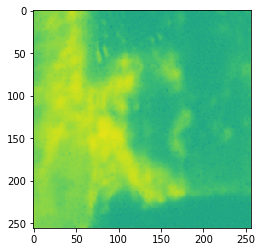

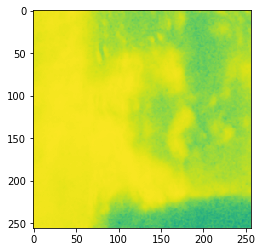

In [14]:
if check_:
    rand_block = (14, 2, 5, 0)
    mask_ = mask.blocks[rand_block]
    M = Y_d.blocks[rand_block].squeeze().compute(scheduler='threads')
    M_pca = Y_svd.blocks[rand_block].squeeze().compute(scheduler='threads')
    Cn_ = local_correlations_fft(M)
    Cn = local_correlations_fft(M_pca)

    plt.imshow(Cn_, vmin=0, vmax=1)
    plt.title('Local correlation before denoise')
    plt.show()
    plt.imshow(Cn, vmin=0, vmax=1)
    plt.title('Local correlation after denoise')
    plt.show()

#### Compare location correlation at a larger region

In [20]:
if check_:
    M = Y_d.blocks[14, 2:4, 2:4].squeeze().compute(scheduler='threads')
    M_pca = Y_svd.blocks[14, 2:4, 2:4].squeeze().compute(scheduler='threads')
    plt.imshow(M.max(axis=-1), vmax=20)
    plt.title('Max projection')
    plt.show()
    Cn_ = local_correlations_fft(M)
    Cn = local_correlations_fft(M_pca)
    plt.imshow(Cn_, vmin=0, vmax=1)
    plt.title('Local correlation before denoise')
    plt.show()
    plt.imshow(Cn, vmin=0, vmax=1)
    plt.title('Local correlation after denoise')
    plt.show()

## Demix
This will generate the follow files at `save_root` folder
* `demix_rlt` for each block

### Check denoised signal

In [83]:
redo_ = True

In [ ]:
if redo_ or (not os.path.exists(f'{save_root}/demix_rlt/')):
    dt = 3
    is_skip = True
    numCores = 100 # ZW: 100 is enough in my testing case, can be larger
    demix_cells(save_root, dt, is_skip=is_skip, numCores = numCores)

Scheduler: tcp://10.36.60.41:36384
Dashboard link: http://10.36.60.41:42390/status


In [57]:
force_bkill_dask()

No unfinished job found in queue <normal>


JOBID      USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
56360674   weiz    RUN   interactiv c11u24      32*e10u31   /bin/bash  Mar 13 11:54


### Check demix results

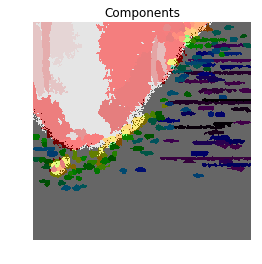

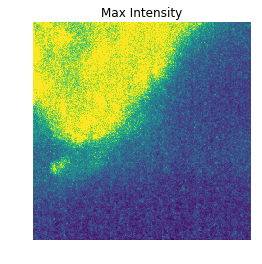

In [82]:
rand_block = (9, 7,5, 0)
check_demix_cells(save_root, rand_block, plot_global=False, plot_mask=True)

In [80]:
with open(fname, 'rb') as f:
    rlt_ = pickle.load(f)

NameError: name 'pickle' is not defined

In [70]:
fname = demix_file_name_block(save_root=save_root, block_id=rand_block)

In [ ]:
import pickle


In [71]:
fname

'./processed/demix_rlt/period_Y_demix_block__9_7_5_0_rlt.pkl'

## Compute df/f
One of three choices
* df is from NMF components (where background is not included) -- preferred
* df is on raw data based on the recomputation of cell F using NMF weights
* df/f on pixels without using NMF weights

### df/f on pixels

In [ ]:
numCores = 70
dff = compute_cell_dff_pixels(dir_root, save_root, 
                              numCores=numCores, 
                              window=baseline_window, 
                              percentile=baseline_percentile)

### df/f on raw cell data

In [ ]:
compute_cell_dff_raw(dir_root, save_root, 
                     numCores=numCores, 
                     window=baseline_window, 
                     percentile=baseline_percentile, 
                     nsplit=nsplit)

### df/f on denoised cell data

In [ ]:
compute_cell_dff_NMF(dir_root, save_root, 
                     numCores=numCores, 
                     window=baseline_window, 
                     percentile=baseline_percentile, 
                     nsplit=nsplit, dt=dt)